# 如何使用 Intel OpenVINO 及 Ultralytics YOLOv11 完成姿態估測
by Jack OmniXRI, 2024/10/15

本程式主要包含下列幾大步驟。  
1. 原始 YOLOv11 推論結果  
2. 轉換到 OpenVINO IR推論結果  
3. 經過 NNCF 壓縮優化推論結果
4. 使用基準測試工具進行比較  
5. 連續影片推論展示

如果想要在本機端上運行本範例，可參考Github提供的「[安裝步驟](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide)」來完成。

原始程式及進階說明：  
https://colab.research.google.com/github/openvinotoolkit/openvino_notebooks/blob/latest/notebooks/yolov11-optimization/yolov11-keypoint-detection.ipynb


## 1. 原始 YOLOv11 推論結果



### 1.1 安裝 Intel OpenVINO 、 Ultralytics(YOLOv11) 及必要套件包
下載及安裝 OpenVINO, NNCF, PyTorch, Ultralytic(YOLOv11), OpenCV 等相關套件包。  
註：由於 OpenVINO 在 Colab 環境下只能在 Intel Xeon CPU 下運行，所以這裡安裝的 PyTorch 是 CPU 版本。

In [ ]:
# 已移除 Colab 的 pip install，請改用 requirements.txt 安裝套件
# pip install -r requirements.txt

### 1.2 下載必要函式庫並引入
下載 notebook_utils.py 到暫存區，並引入 download_file, VideoPlayer, device_widge 函式庫。

In [4]:
from pathlib import Path

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)
from notebook_utils import download_file, VideoPlayer, device_widget

### 1.3 下載測試用影像
下載網路上影像檔 intel_rnb.jpg，可自行替換 url 後影像來源路徑。

In [5]:
# Download a test sample

IMAGE_PATH = Path("data/intel_rnb.jpg")
download_file(
    url="https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/image/intel_rnb.jpg",
    filename=IMAGE_PATH.name,
    directory=IMAGE_PATH.parent,
)

PosixPath('/home/willie/YOLO-model-test/data/intel_rnb.jpg')

### 1.4 指定推論用模型名稱並下載
建立模型名稱清單，可使用下拉盒式選取，預設名稱為為第[0]個，yolo11n-pose。  
這裡可支援 yolov8 及 yolov11 模型名稱，n, s, m, l, x 分別代表模型的大小，從最小到最大，越小推論速度越快但精度略差，反之越大則越慢但精度會提高一些，可依實際需求調整。  

In [6]:
import ipywidgets as widgets

model_id = [
    "yolo11n-pose",
    "yolo11s-pose",
    "yolo11m-pose",
    "yolo11l-pose",
    "yolo11x-pose",
    "yolov8n-pose",
    "yolov8s-pose",
    "yolov8m-pose",
    "yolov8l-pose",
    "yolov8x-pose",
]

model_name = widgets.Dropdown(options=model_id, value=model_id[5], description="Model") #set yolov8n-pose as default model
model_name

Dropdown(description='Model', index=5, options=('yolo11n-pose', 'yolo11s-pose', 'yolo11m-pose', 'yolo11l-pose'…

### 1.5 實例化 YOLO 並測試推論

依上一步驟取得之模型名稱下載模型並實例化成 pose_model  
接著直接使用該模型對先前指定好的影像進行推論，並取得姿態（關節點）結果 res （包含物件外框、類別及置信度）繪製在影像上。  
另外會輸出總時間及各步驟工作所耗費時間，包含前處理（影像轉換等）、推論（姿態估測）及後處理（輸出數值及繪製結果）。  

註：理論上如果只是想取得姿態估測結果，到這一步就可結束了。但這裡可先記下工作耗時及置信度，方便後面和經過 OpenVINO 處理過的內容作比較。  




In [ ]:
# 已移除 Colab 的 pip install，請改用 requirements.txt 安裝套件
# pip install -r requirements.txt


image 1/1 /home/willie/YOLO-model-test/data/intel_rnb.jpg: 480x640 1 person, 127.8ms
Speed: 6.5ms preprocess, 127.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


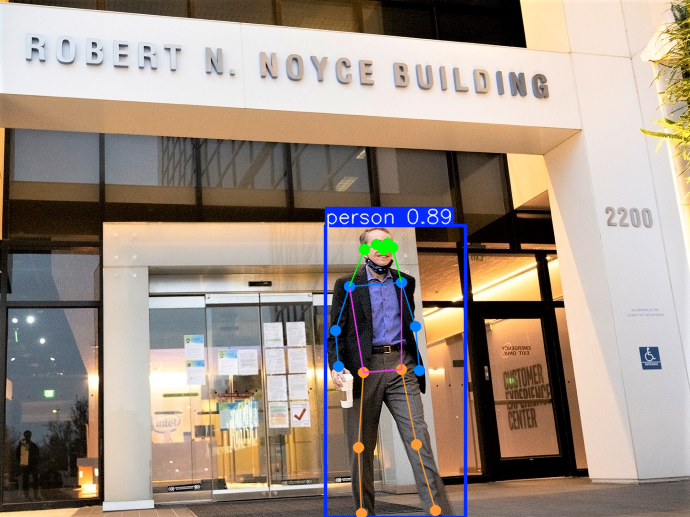

In [7]:
from PIL import Image
from ultralytics import YOLO

POSE_MODEL_NAME = model_name.value

pose_model = YOLO(f"{POSE_MODEL_NAME}.pt")
label_map = pose_model.model.names

res = pose_model(IMAGE_PATH)
Image.fromarray(res[0].plot()[:, :, ::-1])

## 2. 轉換到 OpenVINO IR推論結果


### 2.1 將模型轉換成 OpenVINO IR 格式
Ultralytics 本來就有支援將模型輸出成 Intel OpenVINO IR(xml + bin) 格式，只要執行下列程式即可。  
轉換好的模型會存放在 /yolo11n-pose_openvino_model/ 路徑下。這裡仍保持原有 FP32 資料格式。

註：這裡要保留動態形狀（Dynamic Shape）設定為 True，方便後續工作。

In [8]:
# object detection model
pose_model_path = Path(f"{POSE_MODEL_NAME}_openvino_model/{POSE_MODEL_NAME}.xml")
if not pose_model_path.exists():
    pose_model.export(format="openvino", dynamic=True, half=True)

### 2.2 選擇推論裝置
在 Google Colab 上只能選 CPU ，在本機端則還可選用Intel GPU（內顯）來提升推論速度。  不過一般為了方便，可直接設為 AUTO 讓系統自行選用即可。  

In [10]:
device = device_widget()

device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

### 2.3 測試單張影像
這裡的測試影像沿用步驟1.3，接著測試轉成 Intel OpenVINO IR 格式的模型是否能正確推論。  
結果正確，且推論時間可減少一半以上，推論精度仍接近原來水準。  


Ultralytics 8.3.167 🚀 Python-3.10.13 torch-2.3.0+cpu CPU (13th Gen Intel Core(TM) i9-13900H)
Loading yolov8n-pose_openvino_model for OpenVINO inference...
Using OpenVINO LATENCY mode for batch=1 inference...

image 1/1 /home/willie/YOLO-model-test/data/intel_rnb.jpg: 640x640 2 persons, 66.0ms
Speed: 3.9ms preprocess, 66.0ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)


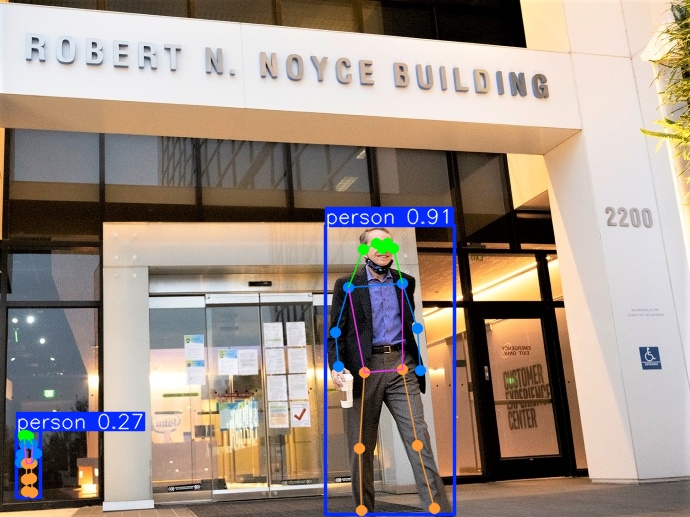

In [17]:
import openvino as ov # 引入 OpenVINO 函式庫

core = ov.Core()
pose_ov_model = core.read_model(pose_model_path)

ov_config = {}
if device.value != "CPU":
    pose_ov_model.reshape({0: [1, 3, 640, 640]})

if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
    ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

pose_compiled_model = core.compile_model(pose_ov_model, device.value, ov_config)

pose_model = YOLO(pose_model_path.parent, task="pose")

if pose_model.predictor is None:
    custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}
    args = {**pose_model.overrides, **custom}
    pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
    pose_model.predictor.setup_model(model=pose_model.model)

pose_model.predictor.model.ov_compiled_model = pose_compiled_model

# 這裡就是直接改掉
res = pose_model(IMAGE_PATH, imgsz=(640,640), rect=False)
Image.fromarray(res[0].plot()[:, :, ::-1])


## 3. 經過 NNCF 壓縮優化推論結果
[NNCF](https://github.com/openvinotoolkit/nncf)  是 OpenVINO 作為模型優化的重要工具， 它提供了多種模型壓縮及優化方式，這裡僅使用到參數量化(Quantization)，即將 FP32 轉換到 INT8。  


### 3.1 指定是否量化
預設 to_quantize value 為 True，即要啟用量化。  

In [103]:
import ipywidgets as widgets

int8_model_pose_path = Path(f"{POSE_MODEL_NAME}_openvino_int8_model/{POSE_MODEL_NAME}.xml")
quantized_pose_model = None

to_quantize = widgets.Checkbox(
    value=True,
    description="Quantization",
    disabled=False,
)

to_quantize

Checkbox(value=True, description='Quantization')

### 3.2 不啟用量化處理方式
若不啟用量化則需使用 skip_kernel_extension 模組來協助略過部份工作。  

In [14]:
# Fetch skip_kernel_extension module
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/skip_kernel_extension.py",
)
open("skip_kernel_extension.py", "w").write(r.text)

%load_ext skip_kernel_extension

### 3.3 產生 NNCF 所需資料集
下載校正用資料，並設定轉換函式，產生 NNCF 所需資料集。  
此步驟需較長時間，請耐心等候。  

In [15]:
if to_quantize.value:

  import nncf
  from typing import Dict

  from zipfile import ZipFile

  from ultralytics.data.utils import DATASETS_DIR
  from ultralytics.utils import DEFAULT_CFG
  from ultralytics.cfg import get_cfg
  from ultralytics.data.utils import check_det_dataset
  from ultralytics.models.yolo.pose import PoseValidator
  from ultralytics.utils.metrics import OKS_SIGMA

  if not int8_model_pose_path.exists():

      DATA_URL = "https://ultralytics.com/assets/coco8-pose.zip"
      CFG_URL = "https://raw.githubusercontent.com/ultralytics/ultralytics/v8.1.0/ultralytics/cfg/datasets/coco8-pose.yaml"

      OUT_DIR = DATASETS_DIR

      DATA_PATH = OUT_DIR / "val2017.zip"
      CFG_PATH = OUT_DIR / "coco8-pose.yaml"

      download_file(DATA_URL, DATA_PATH.name, DATA_PATH.parent)
      download_file(CFG_URL, CFG_PATH.name, CFG_PATH.parent)

      if not (OUT_DIR / "coco8-pose/labels").exists():
          with ZipFile(DATA_PATH, "r") as zip_ref:
              zip_ref.extractall(OUT_DIR)

      args = get_cfg(cfg=DEFAULT_CFG)
      args.data = "coco8-pose.yaml"

      pose_validator = PoseValidator(args=args)
      pose_validator.data = check_det_dataset(args.data)
      pose_validator.stride = 32
      pose_data_loader = pose_validator.get_dataloader(OUT_DIR / "coco8-pose", 1)

      pose_validator.is_coco = True
      pose_validator.names = label_map
      pose_validator.metrics.names = pose_validator.names
      pose_validator.nc = 1
      pose_validator.sigma = OKS_SIGMA


      def transform_fn(data_item:Dict):
          """
          Quantization transform function. Extracts and preprocess input data from dataloader item for quantization.
          Parameters:
            data_item: Dict with data item produced by DataLoader during iteration
          Returns:
              input_tensor: Input data for quantization
          """
          input_tensor = pose_validator.preprocess(data_item)['img'].numpy()
          return input_tensor


      quantization_dataset = nncf.Dataset(pose_data_loader, transform_fn)

val2017.zip:   0%|          | 0.00/334k [00:00<?, ?B/s]

coco8-pose.yaml:   0%|          | 0.00/552 [00:00<?, ?B/s]

100%|██████████| 755k/755k [00:00<00:00, 2.51MB/s]

val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1894.7±1015.8 MB/s, size: 42.4 KB)



val: Scanning /home/willie/YOLO-model-test/datasets/coco8-pose/labels/train... 8 images, 0 backgrounds, 0 corrupt: 100%|██████████| 8/8 [00:00<00:00, 430.31it/s]

val: New cache created: /home/willie/YOLO-model-test/datasets/coco8-pose/labels/train.cache


### 3.4 使用 NNCF 進行模型量化  
開始進行量化，產生新 INT8 模型。  
此步驟需較長時間，請耐心等候。

In [104]:
if to_quantize.value:

  if not int8_model_pose_path.exists():

      ignored_scope = nncf.IgnoredScope(  # post-processing
          subgraphs=[
              nncf.Subgraph(inputs=[f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat",
                                    f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_1",
                                    f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_2",
                                  f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_7"],
                            outputs=[f"__module.model.{22 if 'v8' in POSE_MODEL_NAME else 23}/aten::cat/Concat_9"])
          ]
      )

      # Detection model
      quantized_pose_model = nncf.quantize(
          pose_ov_model,
          quantization_dataset,
          preset=nncf.QuantizationPreset.MIXED,
          ignored_scope=ignored_scope
      )
      print(f"Quantized keypoint detection model will be saved to {int8_model_pose_path}")
      ov.save_model(quantized_pose_model, str(int8_model_pose_path))

INFO:nncf:120 ignored nodes were found by subgraphs in the NNCFGraph
INFO:nncf:Not adding activation input quantizer for operation: 134 __module.model.22/aten::cat/Concat
INFO:nncf:Not adding activation input quantizer for operation: 142 __module.model.22/aten::view/Reshape_3
INFO:nncf:Not adding activation input quantizer for operation: 275 __module.model.22/aten::cat/Concat_1
INFO:nncf:Not adding activation input quantizer for operation: 285 __module.model.22/aten::view/Reshape_4
INFO:nncf:Not adding activation input quantizer for operation: 338 __module.model.22/aten::cat/Concat_2
INFO:nncf:Not adding activation input quantizer for operation: 341 __module.model.22/aten::view/Reshape_5
INFO:nncf:Not adding activation input quantizer for operation: 143 __module.model.22/aten::cat/Concat_7
INFO:nncf:Not adding activation input quantizer for operation: 155 __module.model.22/aten::view/Reshape_9
INFO:nncf:Not adding activation input quantizer for operation: 168 __module.model.22/aten::sl

Output()

Output()

Quantized keypoint detection model will be saved to yolov8n_openvino_int8_model/yolov8n.xml


### 3.5 測試單張影像
這裡的測試影像沿用步驟1.3，接著測試經 NNCF 量化後的模型是否能正確推論。  
結果正確，推論精度仍接近原來水準。  

In [17]:
if to_quantize.value:

  device

In [88]:
import cv2
import numpy as np

def resize_and_pad_image(image, target_size=640, pad_color=(114, 114, 114)):
    """
    將圖片等比例 resize 並補邊，輸出尺寸為 target_size x target_size。
    只做尺寸與補邊，不進行顏色轉換。

    Args:
        image (np.ndarray): OpenCV 讀入的影像 (BGR)
        target_size (int): 輸出影像邊長，預設為 640
        pad_color (tuple): 補邊顏色，預設為灰色 (114,114,114)

    Returns:
        padded_image (np.ndarray): 補邊後的圖像，大小為 (target_size, target_size, 3)
    """
    h, w = image.shape[:2]
    scale = min(target_size / w, target_size / h)
    new_w, new_h = int(w * scale), int(h * scale)

    resized = cv2.resize(image, (new_w, new_h))

    pad_top = (target_size - new_h) // 2
    pad_bottom = target_size - new_h - pad_top
    pad_left = (target_size - new_w) // 2
    pad_right = target_size - new_w - pad_left

    padded = cv2.copyMakeBorder(
        resized,
        top=pad_top, bottom=pad_bottom,
        left=pad_left, right=pad_right,
        borderType=cv2.BORDER_CONSTANT,
        value=pad_color
    )

    return padded


In [89]:
img = cv2.imread("data/1.jpg")  # BGR
padded_img = resize_and_pad_image(img)
cv2.imwrite("padded_1.jpg", padded_img)


True

In [95]:
import cv2
import numpy as np
import json

IMAGE_PATH = Path("data/padded_1.jpg")

if to_quantize.value:
    if quantized_pose_model is None:
        quantized_pose_model = core.read_model()

    # 印出模型的預期輸入 shape
    print("Model input shape:", quantized_pose_model.inputs[0].partial_shape)

    if device.value != "CPU":
        quantized_pose_model.reshape({0: [1, 3, 640, 640]})

    ov_config = {}
    if "GPU" in device.value or ("AUTO" in device.value and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

    quantized_pose_compiled_model = core.compile_model(quantized_pose_model, device.value, ov_config)

    # 印出編譯好的模型預期 shape
    print("Compiled model input shape:", quantized_pose_compiled_model.input(0).shape)

    # 讀取並 resize 圖像
    img = cv2.imread(str(IMAGE_PATH))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (640, 640))
    img_resized = np.transpose(img_resized, (2, 0, 1))[np.newaxis, :].astype(np.float32)

    print("Actual inference input shape:", img_resized.shape)

    # 執行推論
    result_dict = quantized_pose_compiled_model.infer_new_request({0: img_resized})

    # 印出推論結果（通常是 dict，會有 'output' 或 keypoints 資料）
    print("推論結果:", result_dict)
    
result_dict = quantized_pose_compiled_model.infer_new_request({0: img_resized})
parsed_result = parse_yolo_output(result_dict, frame_index=0)

# 儲存為 JSON
import json
with open("data/result.json", "w", encoding="utf-8") as f:
    json.dump(parsed_result, f, indent=2)



Model input shape: [1,3,640,640]
Compiled model input shape: [1,3,640,640]
Actual inference input shape: (1, 3, 640, 640)
推論結果: {<ConstOutput: names[] shape[1,56,8400] type: f32>: array([[[     13.187,      20.948,      27.764, ...,       516.5,      541.15,      557.78],
        [     15.347,      11.893,      6.3565, ...,      581.55,      566.47,      534.66],
        [     41.251,      49.505,      56.199, ...,      247.93,      217.82,      194.55],
        ...,
        [   0.025836,      8.7519,      14.393, ...,      488.98,      522.27,      564.53],
        [     24.462,      22.762,      22.138, ...,      627.08,      614.55,      610.54],
        [    0.11924,     0.16419,      0.1781, ...,    0.042734,    0.047144,    0.057149]]], dtype=float32)}


## 4. 使用基準測試工具進行比較

### 4.1 使用基準測試工具測試
[Benchmark Tool](https://docs.openvino.ai/2024/learn-openvino/openvino-samples/benchmark-tool.html) 是 OpenVINO 提供的一組工具程式，方便連續測試用，可指定不同推論裝置、連續工作時間（預設60秒，可加 -t 指定秒數），再去計算每秒可執行次數及每次推論所需最小、最大及平均時間，方便進行性能比較。這和單張略微不同，可省去許多共同時間，如模型載入、編譯等。  
若在本機端執行時可將裝置設為 GPU 進行比較。  

In [19]:
if to_quantize.value:

  device

### 4.2 使用 FP32 模型推論

In [20]:
if int8_model_pose_path.exists():
    # Inference FP32 model (OpenVINO IR)
    !benchmark_app -m $pose_model_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.2.0-19140-c01cd93e24d-releases/2025/2
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.2.0-19140-c01cd93e24d-releases/2025/2
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 21.94 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [?,3,?,?]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_9) : f32 / [...] / [?,56,21..]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batch si

### 4.3 使用 INT8 模型推論

In [21]:
if int8_model_pose_path.exists():
    # Inference INT8 model (OpenVINO IR)
    !benchmark_app -m $int8_model_pose_path -d $device.value -api async -shape "[1,3,640,640]" -t 15

[Step 1/11] Parsing and validating input arguments
[ INFO ] Parsing input parameters
[Step 2/11] Loading OpenVINO Runtime
[ INFO ] OpenVINO:
[ INFO ] Build ................................. 2025.2.0-19140-c01cd93e24d-releases/2025/2
[ INFO ] 
[ INFO ] Device info:
[ INFO ] AUTO
[ INFO ] Build ................................. 2025.2.0-19140-c01cd93e24d-releases/2025/2
[ INFO ] 
[ INFO ] 
[Step 3/11] Setting device configuration
[ WARNING ] Performance hint was not explicitly specified in command line. Device(AUTO) performance hint will be set to PerformanceMode.THROUGHPUT.
[Step 4/11] Reading model files
[ INFO ] Loading model files
[ INFO ] Read model took 29.35 ms
[ INFO ] Original model I/O parameters:
[ INFO ] Model inputs:
[ INFO ]     x (node: x) : f32 / [...] / [1,3,640,640]
[ INFO ] Model outputs:
[ INFO ]     ***NO_NAME*** (node: __module.model.22/aten::cat/Concat_9) : f32 / [...] / [1,56,8400]
[Step 5/11] Resizing model to match image sizes and given batch
[ INFO ] Model batc

## 5. 連續影片推論展示



### 5.1 建立推論函式
run_keypoint_detection 這個函式包括模型載入、影像載入、推論及繪製結果

影片補邊程式

In [ ]:
import cv2
import numpy as np
from pathlib import Path

def letterbox_image(image, target_size=(640, 640), color=(114, 114, 114)):
    original_h, original_w = image.shape[:2]
    target_w, target_h = target_size

    scale = min(target_w / original_w, target_h / original_h)
    new_w, new_h = int(original_w * scale), int(original_h * scale)

    resized_image = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    dw = target_w - new_w
    dh = target_h - new_h
    top, bottom = dh // 2, dh - dh // 2
    left, right = dw // 2, dw - dw // 2

    padded_image = cv2.copyMakeBorder(
        resized_image, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color
    )

    return padded_image, (scale, scale), (left, top)

def process_video_with_letterbox(video_path, output_path=None, target_size=(640, 640), show=True):
    """
    逐幀處理影片，將每一幀等比例縮放並補邊成 YOLO 輸入格式。

    參數：
        video_path: 輸入影片路徑
        output_path: 若提供，將轉換後影片儲存到該路徑
        target_size: 輸出畫面尺寸（預設 640x640）
        show: 是否顯示畫面（預設 True）
    """
    cap = cv2.VideoCapture(str(video_path))
    if not cap.isOpened():
        print(f"❌ 無法開啟影片：{video_path}")
        return

    # 影片輸出設定
    if output_path:
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(str(output_path), fourcc, cap.get(cv2.CAP_PROP_FPS), target_size)
    else:
        out = None

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        padded_frame, ratio, pad = letterbox_image(frame, target_size)

        if show:
            cv2.imshow("YOLO Letterbox Format", padded_frame)
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break

        if out:
            out.write(padded_frame)

    cap.release()
    if out:
        out.release()
    if show:
        cv2.destroyAllWindows()


In [12]:
import collections
import time
from IPython import display
import cv2
import numpy as np


def run_keypoint_detection(
    source=0,
    flip=False,
    use_popup=False,
    skip_first_frames=0,
    model=pose_model,
    device=device.value,
):
    player = None

    ov_config = {}
    # if device != "CPU":
    #     model.reshape({0: [1, 3, 640, 640]})

    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

    compiled_model = core.compile_model(model, device, ov_config)

    if pose_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}  # method defaults
        args = {**seg_model.overrides, **custom}
        pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
        pose_model.predictor.setup_model(model=pose_model.model)

    pose_model.predictor.model.ov_compiled_model = compiled_model

    try:
        # Create a video player to play with target fps.
        player = VideoPlayer(source=source, flip=flip, fps=10, skip_first_frames=skip_first_frames)
        # Start capturing.
        player.start()
        if use_popup:
            title = "Press ESC to Exit"
            cv2.namedWindow(winname=title, flags=cv2.WINDOW_GUI_NORMAL | cv2.WINDOW_AUTOSIZE)

        processing_times = collections.deque()
        while True:
            # Grab the frame.
            frame = player.next()
            if frame is None:
                print("Source ended")
                break
            # If the frame is larger than full HD, reduce size to improve the performance.
            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(
                    src=frame,
                    dsize=None,
                    fx=scale,
                    fy=scale,
                    interpolation=cv2.INTER_AREA,
                )
            # Get the results
            input_image = np.array(frame)

            start_time = time.time()

            detections = pose_model(input_image)
            stop_time = time.time()
            frame = detections[0].plot()

            processing_times.append(stop_time - start_time)
            # Use processing times from last 200 frames.
            if len(processing_times) > 200:
                processing_times.popleft()

            _, f_width = frame.shape[:2]
            # Mean processing time [ms].
            processing_time = np.mean(processing_times) * 1000
            fps = 1000 / processing_time
            cv2.putText(
                img=frame,
                text=f"Inference time: {processing_time:.1f}ms ({fps:.1f} FPS)",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_COMPLEX,
                fontScale=f_width / 1000,
                color=(0, 0, 255),
                thickness=1,
                lineType=cv2.LINE_AA,
            )
            # Use this workaround if there is flickering.
            if use_popup:
                cv2.imshow(winname=title, mat=frame)
                key = cv2.waitKey(1)
                # escape = 27
                if key == 27:
                    break
            else:
                # Encode numpy array to jpg.
                _, encoded_img = cv2.imencode(ext=".jpg", img=frame, params=[cv2.IMWRITE_JPEG_QUALITY, 100])
                # Create an IPython image.
                i = display.Image(data=encoded_img)
                # Display the image in this notebook.
                display.clear_output(wait=True)
                display.display(i)
    # ctrl-c
    except KeyboardInterrupt:
        print("Interrupted")
    # any different error
    except RuntimeError as e:
        print(e)
    finally:
        if player is not None:
            # Stop capturing.
            player.stop()
        if use_popup:
            cv2.destroyAllWindows()

單純推論與輸出

In [96]:
import os
import collections
import time
import json
import cv2
import numpy as np

# ===============================================
# ⚠️ 這支程式會把推論結果先用 collections.deque()（佇列）收集，
# ⚠️ 在寫入 JSON 時轉成 list 來存檔（因 JSON 不支援 deque）。
#
# ➡️ 如果之後要再提取回來使用佇列，可以這樣做：
#     import json, collections
#     with open("path_to_json.json", "r", encoding="utf-8") as f:
#         data = json.load(f)
#     my_queue = collections.deque(data)
# ===============================================

def run_inference_to_json(
    source=0,
    flip=False,
    skip_first_frames=0,
    target_fps=10,
    output_dir="output_jsons",
    model=pose_model,
    device=device.value,
):
    player = None

    ov_config = {}
    if "GPU" in device or ("AUTO" in device and "GPU" in core.available_devices):
        ov_config = {"GPU_DISABLE_WINOGRAD_CONVOLUTION": "YES"}

    compiled_model = core.compile_model(model, device, ov_config)

    if pose_model.predictor is None:
        custom = {"conf": 0.25, "batch": 1, "save": False, "mode": "predict"}
        args = {**seg_model.overrides, **custom}
        pose_model.predictor = pose_model._smart_load("predictor")(overrides=args, _callbacks=pose_model.callbacks)
        pose_model.predictor.setup_model(model=pose_model.model)

    pose_model.predictor.model.ov_compiled_model = compiled_model

    # 處理 output 檔名
    if isinstance(source, str):
        video_name = os.path.splitext(os.path.basename(source))[0]
    else:
        video_name = "camera_capture"
    os.makedirs(output_dir, exist_ok=True)
    output_json_path = os.path.join(output_dir, f"{video_name}.json")

    json_results = collections.deque()
    try:
        player = VideoPlayer(source=source, flip=flip, fps=30, skip_first_frames=skip_first_frames)
        player.start()

        # 取得影片 FPS
        capture = cv2.VideoCapture(source)
        video_fps = capture.get(cv2.CAP_PROP_FPS)
        capture.release()
        if video_fps <= 0 or np.isnan(video_fps):
            video_fps = 30
        print(f"影片 FPS = {video_fps:.2f}")

        skip_frames = max(int(round(video_fps / target_fps)), 1)
        print(f"將每 {skip_frames} 幀做一次推論以達成 {target_fps} FPS")

        frame_counter = 0
        processing_times = collections.deque()

        while True:
            frame = player.next()
            if frame is None:
                print("Source ended")
                break

            frame_counter += 1
            if frame_counter % skip_frames != 0:
                continue

            scale = 1280 / max(frame.shape)
            if scale < 1:
                frame = cv2.resize(frame, dsize=None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

            input_image = np.array(frame)

            try:
                start_time = time.time()
                detections = pose_model(input_image)
                stop_time = time.time()

                detection = detections[0]
                result = {
                    "boxes": detection.boxes.xyxy.tolist() if hasattr(detection, "boxes") else [],
                    "keypoints": detection.keypoints.xy.tolist() if hasattr(detection, "keypoints") else []
                }
                json_results.append(result)

                processing_times.append(stop_time - start_time)
                if len(processing_times) > 200:
                    processing_times.popleft()
                processing_time = np.mean(processing_times) * 1000
                fps = 1000 / processing_time
                print(f"[推論時間: {processing_time:.1f}ms ({fps:.1f} FPS)]")

            except Exception as e:
                print(f"[推論錯誤]: {e}")

    except Exception as e:
        print(f"捕捉到錯誤: {e}")
    finally:
        if player is not None:
            player.stop()
        # 寫入時轉成 list
        with open(output_json_path, "w", encoding="utf-8") as f:
            json.dump(list(json_results), f, indent=2)
        print(f"骨架與物件框結果已輸出至: {output_json_path}")


物件框偵測與繪圖

In [108]:
import cv2
import time
from ultralytics import YOLO

def process_video_with_yolo_and_fps_control(
    video_path,
    target_fps=10,
    model_path="yolov8n.pt",
    show=True
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ 無法開啟影片：{video_path}")
        return

    # 載入 YOLO 模型
    model = YOLO(model_path)

    # 計算原始 FPS 與跳幀間隔
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    original_fps_rounded = round(original_fps)
    frame_interval = max(1, round(original_fps_rounded / target_fps))
    print(f"🎞️ 原始 FPS: {original_fps:.2f} → 目標 FPS: {target_fps}，每 {frame_interval} 幀取 1 幀")

    frame_idx = 0
    last_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # 只處理每隔 frame_interval 幀的影像
        if frame_idx % frame_interval == 0:
            # 🔁 計時：前處理 + 推論
            current_time = time.time()
            fps = 1 / (current_time - last_time + 1e-6)
            last_time = current_time

            results = model(frame)[0]
            annotated_frame = results.plot()

            # 🖥️ 在畫面上顯示 FPS
            cv2.putText(
                annotated_frame,
                f"FPS: {fps:.2f}",
                (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                2
            )

            # ✅ 新增：在 console 輸出 FPS
            print(f"[Frame {frame_idx}] Processing FPS: {fps:.2f}")

            if show:
                cv2.imshow("YOLO Detection", annotated_frame)
                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

        frame_idx += 1

    cap.release()
    if show:
        cv2.destroyAllWindows()

物件框偵測與純輸出

In [1]:
import cv2
import time
import json
from pathlib import Path
from ultralytics import YOLO

def process_video_to_json(
    video_path,
    output_dir,
    target_fps=10,
    model_path="yolov8n.pt",
    confidence_threshold=0.3
):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ 無法開啟影片：{video_path}")
        return

    # 載入模型
    model = YOLO(model_path)

    # 準備輸出路徑
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    video_name = Path(video_path).stem  # e.g. "your_video"
    output_path = output_dir / f"{video_name}.json"

    # 取得原始 fps 並計算處理間隔
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    original_fps_rounded = round(original_fps)
    frame_interval = max(1, round(original_fps_rounded / target_fps))
    print(f"🎞️ 原始 FPS: {original_fps:.2f} → 目標 FPS: {target_fps}，每 {frame_interval} 幀取 1 幀")

    results_list = []
    frame_idx = 0
    last_time = time.time()

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_interval == 0:
            start = time.time()
            results = model(frame)[0]

            frame_result = {
                "objects": []
            }

            for box in results.boxes:
                conf = float(box.conf[0])
                if conf < confidence_threshold:
                    continue

                class_id = int(box.cls[0])
                class_name = model.names[class_id]
                bbox = list(map(int, box.xyxy[0]))

                frame_result["objects"].append({
                    "class_id": class_id,
                    "class_name": class_name,
                    "confidence": round(conf, 4),
                    "bbox": bbox
                })

            results_list.append(frame_result)

            fps = 1 / (time.time() - last_time + 1e-6)
            last_time = time.time()
            print(f"[Frame {frame_idx}] Detected {len(frame_result['objects'])} objects | FPS: {fps:.2f}")

        frame_idx += 1

    cap.release()

    # 一次寫入整個 JSON 結果
    with open(output_path, "w") as f:
        json.dump(results_list, f, indent=2)

    print(f"✅ 已完成，儲存至 {output_path}（共 {len(results_list)} 幀）")


### 5.2 取得影片進行姿態估測
呼叫 run_keypoint_detection 進行推論，可依需要改變影片來源、推論裝置及模型。    
* 若在本地端運行時，將 Source 改成 0 ，就可直接支援本機（桌機或筆電)上的第1部網路攝影機。若有多部則修改為 1 到 N 。  
* 若在 Colab 上遇到畫面閃爍問題時，可將 use_popup 設為 True 來改善。  
* 若想多次測試不同影片、裝置（CPU / GPU / AUTO）或模型(pose_ov_model / quantized_pose_model)，可直接修改參數，單獨運行本格程式即可，不用全部程式重新運行。  


In [45]:
# VIDEO_SOURCE = "https://storage.openvinotoolkit.org/repositories/openvino_notebooks/data/data/video/people.mp4"
VIDEO_SOURCE = "data/IMG_7704.mp4"

In [110]:
device

Dropdown(description='Device:', index=1, options=('CPU', 'AUTO'), value='AUTO')

In [15]:
quantized_pose_model = core.read_model("yolov8n-pose_openvino_int8_model/yolov8n-pose.xml")

In [ ]:
process_video_with_letterbox("data/IMG_7704.mp4", output_path="data/formmed.mp4", show=False)

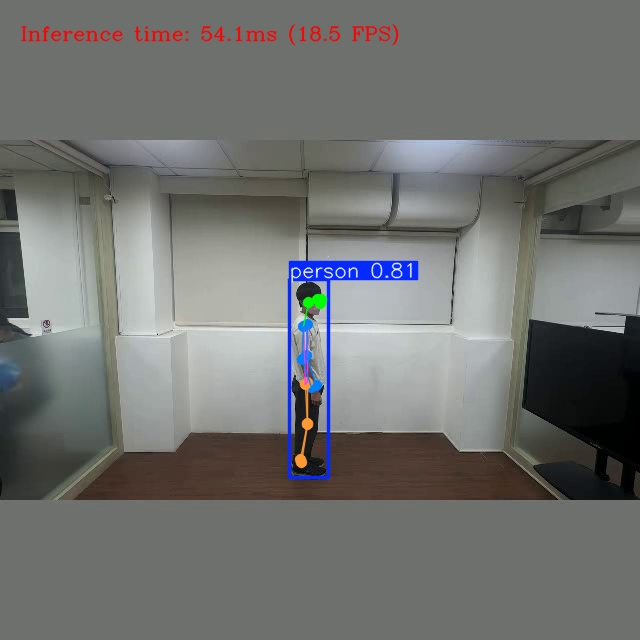

Source ended


In [16]:
run_keypoint_detection(
    source="data/formmed.mp4",
    flip=False,
    use_popup=False,
    model=quantized_pose_model, # pose_ov_model, quantized_pose_model
    device=device.value,
)

In [114]:
run_inference_to_json(
    source="data/padded_1.mp4",
    target_fps=10,
    output_dir="results",
    model=quantized_pose_model
)

影片 FPS = 25.00
將每 2 幀做一次推論以達成 10 FPS

0: 640x640 2 persons, 105.8ms
Speed: 4.0ms preprocess, 105.8ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
[推論時間: 116.2ms (8.6 FPS)]

0: 640x640 2 persons, 83.3ms
Speed: 2.9ms preprocess, 83.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
[推論時間: 104.5ms (9.6 FPS)]

0: 640x640 2 persons, 82.9ms
Speed: 2.3ms preprocess, 82.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
[推論時間: 100.3ms (10.0 FPS)]

0: 640x640 2 persons, 91.4ms
Speed: 2.9ms preprocess, 91.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
[推論時間: 100.8ms (9.9 FPS)]

0: 640x640 2 persons, 91.3ms
Speed: 1.9ms preprocess, 91.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
[推論時間: 100.5ms (9.9 FPS)]

0: 640x640 2 persons, 85.1ms
Speed: 2.0ms preprocess, 85.1ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
[推論時間: 99.1ms (10.1 FPS)]

0: 640x640 2 persons, 75.1ms
Speed: 1.7ms

In [107]:
process_video_with_yolo_and_fps_control("data/formmed.mp4", target_fps=10,show=True)


🎞️ 原始 FPS: 59.94 → 目標 FPS: 10，每 6 幀取 1 幀

0: 640x640 1 person, 249.5ms
Speed: 27.8ms preprocess, 249.5ms inference, 9.8ms postprocess per image at shape (1, 3, 640, 640)
[Frame 0] Processing FPS: 11.79

0: 640x640 1 person, 1 tv, 98.2ms
Speed: 1.6ms preprocess, 98.2ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)
[Frame 6] Processing FPS: 1.95

0: 640x640 1 person, 1 tv, 93.0ms
Speed: 3.0ms preprocess, 93.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
[Frame 12] Processing FPS: 8.12

0: 640x640 1 person, 1 tv, 101.2ms
Speed: 1.6ms preprocess, 101.2ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)
[Frame 18] Processing FPS: 8.92

0: 640x640 1 person, 1 tv, 85.0ms
Speed: 1.6ms preprocess, 85.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[Frame 24] Processing FPS: 8.55

0: 640x640 1 person, 1 tv, 83.3ms
Speed: 1.8ms preprocess, 83.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
[Frame 30

In [82]:
process_video_to_json(
    video_path="data/formmed.mp4",
    output_dir="target_results",
    target_fps=10,
    model_path="yolov8n.pt",
    confidence_threshold=0.3
)


🎞️ 原始 FPS: 59.94 → 目標 FPS: 10，每 6 幀取 1 幀

0: 640x640 1 person, 87.9ms
Speed: 3.1ms preprocess, 87.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)
[Frame 0] Detected 1 objects | FPS: 5.85

0: 640x640 1 person, 1 tv, 83.0ms
Speed: 2.4ms preprocess, 83.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)
[Frame 6] Detected 2 objects | FPS: 10.03

0: 640x640 1 person, 1 tv, 71.4ms
Speed: 1.7ms preprocess, 71.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
[Frame 12] Detected 2 objects | FPS: 11.91

0: 640x640 1 person, 1 tv, 75.0ms
Speed: 2.2ms preprocess, 75.0ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
[Frame 18] Detected 2 objects | FPS: 11.34

0: 640x640 1 person, 1 tv, 65.1ms
Speed: 1.6ms preprocess, 65.1ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)
[Frame 24] Detected 2 objects | FPS: 13.13

0: 640x640 1 person, 1 tv, 77.9ms
Speed: 2.2ms preprocess, 77.9ms inference, 1.1ms postproce